# Importing Libraries

In [1]:
# table manipulation, calculating
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100) # increase the maximum number of columns

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# learning
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
import lightgbm as lgb    

# hyper parameter tuning
import optuna
import optuna.visualization as vis
from IPython.display import IFrame, display

# Ignore all warnings
import warnings
warnings.simplefilter("ignore")

# Importing datasets

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

In [3]:
df_train

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


In [4]:
df_test

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4
...,...,...,...,...,...,...,...,...,...,...,...,...
725,2915,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3
726,2916,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2
727,2917,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9
728,2918,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5


# EDA

## detail : https://www.kaggle.com/code/leonchani/eda-inspection-for-binary-prediction-with-rainfall/notebook#competiton-:-Binary-Prediction-with-a-Rainfall-Dataset

# Preprocessing

# Feature Engineering

# Modeling

In [5]:
SEED = 42
NUM_SPLITS = 10 # try different folds

In [6]:
X = df_train.drop(columns=["rainfall"])
y = df_train["rainfall"]

In [7]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 0.2),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 0.2),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 60),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-3, 1e-1),
        'verbosity': -1,
        'early_stopping_rounds': 100,
        'random_state': SEED,
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'drop_rate': trial.suggest_float('drop_rate', 0.0, 0.2),
        'max_bin': trial.suggest_int('max_bin', 128, 512),
    }

    cv = KFold(n_splits=NUM_SPLITS, random_state=SEED, shuffle=True)
    scores = []

    for fold, (train_index, valid_index) in enumerate(cv.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_val = y.iloc[train_index], y.iloc[valid_index]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc')

        y_pred_val = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred_val)
        scores.append(score)

    return sum(scores) / len(scores)  # Returns the average AUC

In [8]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# Train the model with optimized parameters
best_params = trial.params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'early_stopping_rounds': 100,
    'random_state': SEED,
})

cv = KFold(n_splits=NUM_SPLITS, random_state=SEED, shuffle=True)
scores = []
models = []

for fold, (train_index, valid_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_val = y.iloc[train_index], y.iloc[valid_index]

    model = lgb.LGBMClassifier(**best_params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc')

    y_pred_val = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_val)
    scores.append(score)
    models.append(model)

print('CV scores:', scores)
print('CV mean score:', sum(scores) / len(scores))

[I 2025-03-25 13:59:35,272] A new study created in memory with name: no-name-776629b5-a884-4392-841c-b4e23ce3824e
[I 2025-03-25 13:59:35,897] Trial 0 finished with value: 0.8963740917914496 and parameters: {'learning_rate': 0.02528586526010927, 'num_leaves': 26, 'max_depth': 8, 'feature_fraction': 0.8886925276463131, 'bagging_fraction': 0.5201720199015416, 'bagging_freq': 4, 'lambda_l1': 0.09051848644096856, 'lambda_l2': 0.03270232641476192, 'min_child_samples': 11, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.035970529177705, 'min_gain_to_split': 0.4080265529596786, 'drop_rate': 0.04413365691167033, 'max_bin': 162}. Best is trial 0 with value: 0.8963740917914496.
[I 2025-03-25 13:59:36,558] Trial 1 finished with value: 0.8969945302419845 and parameters: {'learning_rate': 0.01756294211614657, 'num_leaves': 35, 'max_depth': 7, 'feature_fraction': 0.7555527588051434, 'bagging_fraction': 0.6057000750663992, 'bagging_freq': 3, 'lambda_l1': 0.053381127447270235, 'lambda_l2': 0.02180

Best trial:
  Value: 0.9011927010901823
  Params: 
    learning_rate: 0.043737839800685976
    num_leaves: 28
    max_depth: 10
    feature_fraction: 0.7620560854136262
    bagging_fraction: 0.5691079243891185
    bagging_freq: 2
    lambda_l1: 0.1694298303431855
    lambda_l2: 0.07746709578214517
    min_child_samples: 18
    min_data_in_leaf: 56
    min_sum_hessian_in_leaf: 0.09470738686763597
    min_gain_to_split: 0.22690731149114454
    drop_rate: 0.001030127416669583
    max_bin: 378
CV scores: [0.846301335972291, 0.8973922902494331, 0.9110623781676412, 0.887785875848203, 0.9423732666515118, 0.8731860515486246, 0.9349112426035503, 0.9458245243128963, 0.8921578421578422, 0.8809322033898305]
CV mean score: 0.9011927010901823


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

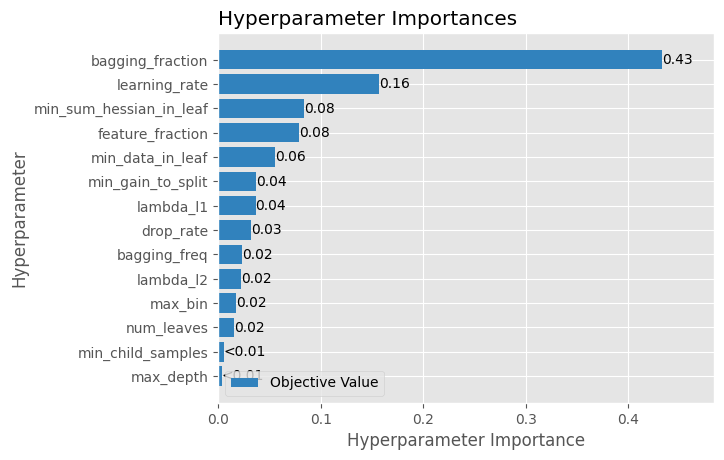

In [9]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [10]:
# Parameter Importance Analysis
fig_importances = vis.plot_param_importances(study)
fig_importances.write_html("parameter_importances.html")

# Optimization history
fig_history = vis.plot_optimization_history(study)
fig_history.write_html("optimization_history.html")

# Display the saved HTML files inline using IFrame
display(IFrame(src="optimization_history.html", width="100%", height=500))
display(IFrame(src="parameter_importances.html", width="100%", height=500))

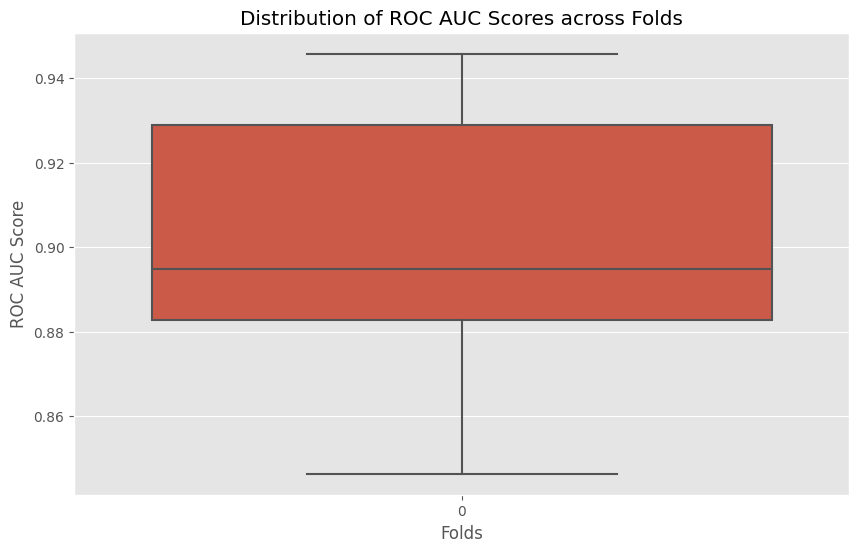

Scores: [0.846301335972291, 0.8973922902494331, 0.9110623781676412, 0.887785875848203, 0.9423732666515118, 0.8731860515486246, 0.9349112426035503, 0.9458245243128963, 0.8921578421578422, 0.8809322033898305]


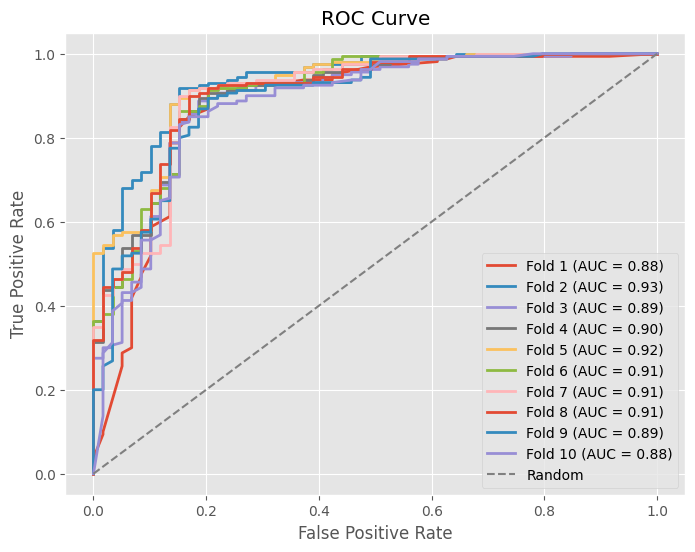

Cross-validated ROC AUC score: 0.90119 +/- 0.03067


In [11]:
# Visualize the scores of each fold with a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores)
plt.title('Distribution of ROC AUC Scores across Folds')
plt.xlabel('Folds')
plt.ylabel('ROC AUC Score')
plt.show()

# Display the scores of each fold in a list
print("Scores:", scores)

# Plot the ROC curve for each fold
plt.figure(figsize=(8, 6))
for fold, model in enumerate(models):
    y_pred_val = model.predict_proba(X.iloc[valid_index])[:, 1]
    fpr, tpr, thresholds = roc_curve(y.iloc[valid_index], y_pred_val)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Fold {fold+1} (AUC = {roc_auc:.2f})')

# diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Graph settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Shows the mean and standard deviation of AUC scores
print(f'Cross-validated ROC AUC score: {np.mean(scores):.5f} +/- {np.std(scores):.5f}') 

# Select Features

## feature_importance

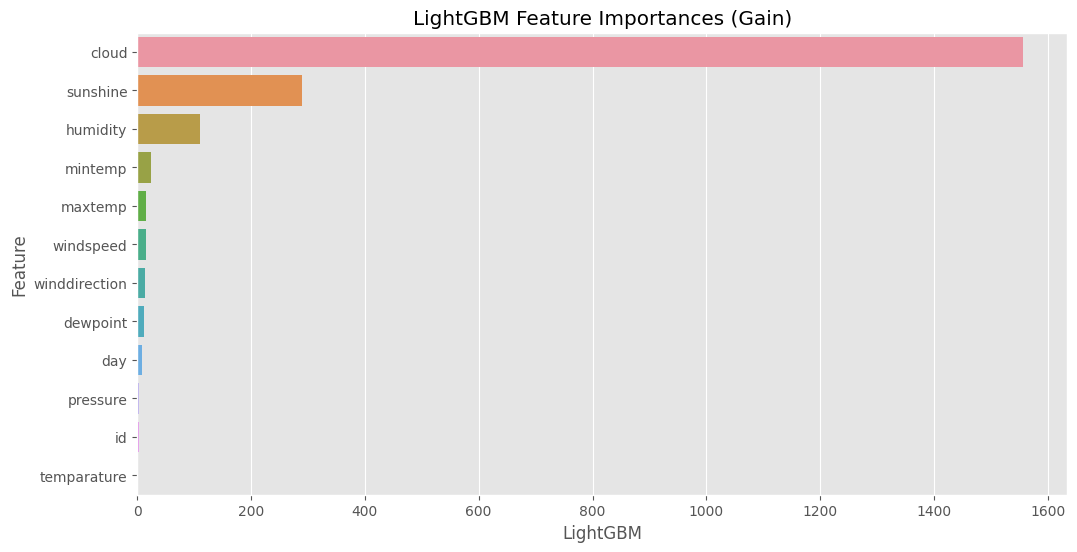

,Feature,LightGBM
8,cloud,1556.105089
9,sunshine,290.017636
7,humidity,109.901521
5,mintemp,23.803650
3,maxtemp,15.743510
11,windspeed,15.194060
10,winddirection,13.744300
6,dewpoint,11.709510
1,day,7.668870
2,pressure,4.007300


In [12]:
# Get the importance of features for each model using gain
lgb_importances = model.booster_.feature_importance(importance_type='gain')

# Get the name of the feature
feature_names = X.columns

# Summarize feature importance in a DataFrame
df_importances = pd.DataFrame({
    'Feature': feature_names,
    'LightGBM': lgb_importances,
})

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='LightGBM', y='Feature', data=df_importances.sort_values(by='LightGBM', ascending=False))
plt.title('LightGBM Feature Importances (Gain)')
plt.show()

display(df_importances.sort_values(by='LightGBM', ascending=False))

## SHAP

In [13]:
import shap

# LGBM SHAP values
explainer_lgb = shap.TreeExplainer(model)
shap_values_lgb = explainer_lgb.shap_values(X)

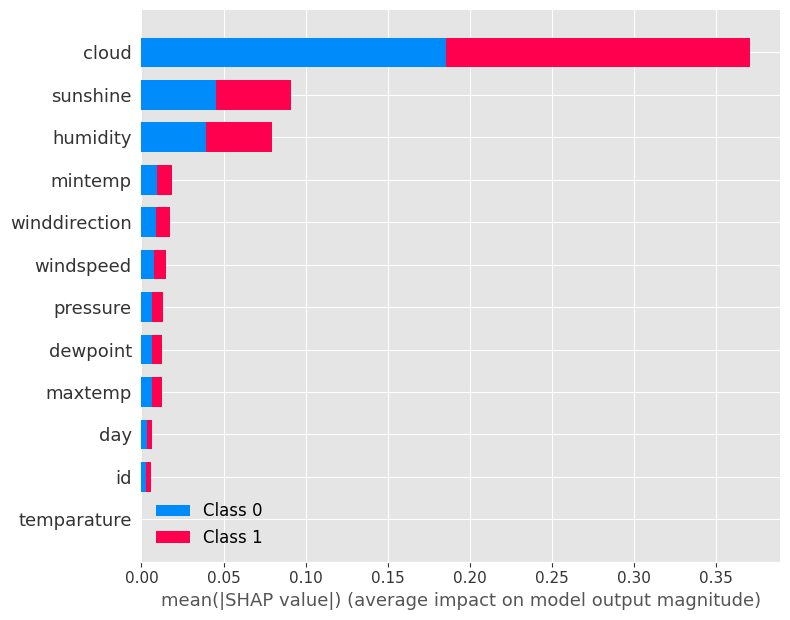

In [14]:
shap.summary_plot(shap_values_lgb, X)

In [15]:
# If shap_values_lgb is a list, convert it to a NumPy array
if isinstance(shap_values_lgb, list):
    shap_values_lgb = np.array(shap_values_lgb)

# Handling the multiclass classification case
if len(shap_values_lgb.shape) == 3:
    shap_importance = np.abs(shap_values_lgb).mean(axis=1).mean(axis=0)
# Handling binary classification cases
else:
    shap_importance = np.abs(shap_values_lgb).mean(axis=0)

# Store in DataFrame
df_importance = pd.DataFrame({
    'feature': X.columns,
    'shap_importance': shap_importance
})

# Sort by importance
df_importance = df_importance.sort_values('shap_importance', ascending=False)

# Show results
display(df_importance)

,feature,shap_importance
8,cloud,0.185151
9,sunshine,0.045506
7,humidity,0.039594
5,mintemp,0.009315
10,winddirection,0.008796
11,windspeed,0.007432
2,pressure,0.006630
6,dewpoint,0.006295
3,maxtemp,0.006136
1,day,0.003148


# Prediction

In [16]:
test_id = df_test["id"]
test = df_test
submit_score = []

for fold_, model in enumerate(models):
    # predict test data
    pred_ = model.predict_proba(test)[:, 1]
    submit_score.append(pred_)

# predict test data
pred = np.mean(submit_score, axis=0)

# Submission

In [17]:
submission = pd.DataFrame({
    'id': test_id,
    'rainfall': pred
})

# Save
submission.to_csv('submission.csv', index=False)

submission

,id,rainfall
0,2190,0.894095
1,2191,0.896582
2,2192,0.855062
3,2193,0.387556
4,2194,0.347272
...,...,...
725,2915,0.882150
726,2916,0.797339
727,2917,0.881874
728,2918,0.895354
